In [20]:
def compute_f1_scores(pred_pt, gold_pt, verbose=True):
    """
    Function to compute F1 scores with pred and gold quads
    The input needs to be already processed
    """
    # number of true postive, gold standard, predictions
    n_tp, n_gold, n_pred = 0, 0, 0

    for i in range(len(pred_pt)):
        n_gold += len(gold_pt[i])
        n_pred += len(pred_pt[i])

        for t in pred_pt[i]:
            if t in gold_pt[i]:
                n_tp += 1

    if verbose:
        print(
            f"number of gold spans: {n_gold}, predicted spans: {n_pred}, hit: {n_tp}"
        )

    precision = float(n_tp) / float(n_pred) if n_pred != 0 else 0
    recall = float(n_tp) / float(n_gold) if n_gold != 0 else 0
    f1 = 2 * precision * recall / (
        precision + recall) if precision != 0 or recall != 0 else 0
    scores = {
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'accuracy': n_tp / n_gold * 100
    }

    return scores

def dict_to_list(aspect_list, sentiment_elements):
    tuples = []
    for aspect in aspect_list:
        tuple = []
        for key in sentiment_elements:
            tuple.append(aspect[key])
        tuples.append(tuple)
    return tuples

In [21]:
import json
import numpy as np
f1_scores_all = {}
model = "gemma3_27b"
seeds = ["seed_42", "seed_43"]
modes = ["random", "rag"]

for mode in modes:
  for dataset_name in ["rest16", "flightabsa", "coursera", "hotels"]:
    for task in ["tasd", "acd", "asqp"]:
        f1_scores = []
        k_list = []
        
        for k in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            f1_scores_per_seed = []
            
            if mode == "random":
                pred_phrase = "predictions_random"
            else:
                pred_phrase = "predictions"
            
            # Statistische Analyse: Vergleich RAG vs Random für jede Task-Dataset-Kombination
            for seed in seeds:
                try:
                    with open(f"./{pred_phrase}/{seed}/{task}/{model}/{k}/{dataset_name}/predictions.json", 'r') as f:
                       data = json.load(f)
                except FileNotFoundError:
                    continue
                
                sentiment_elements = list(data[0]["gold"][0].keys())
                
                preds = [dict_to_list(example["predicted"], sentiment_elements) for example in data]
                golds = [dict_to_list(example["gold"], sentiment_elements) for example in data]

                scores = compute_f1_scores(preds, golds, verbose=False)
                f1_scores_per_seed.append(scores["f1"])
            
            # Nur fortfahren wenn wir Daten für mindestens einen Seed haben
            if f1_scores_per_seed:
                # Mittelwert über alle verfügbaren Seeds
                avg_f1 = np.mean(f1_scores_per_seed)
                f1_scores.append(avg_f1)
                k_list.append(k)

        f1_scores_all[f"{dataset_name}_{task}_{mode}"] = {"f1": f1_scores, "k": k_list}

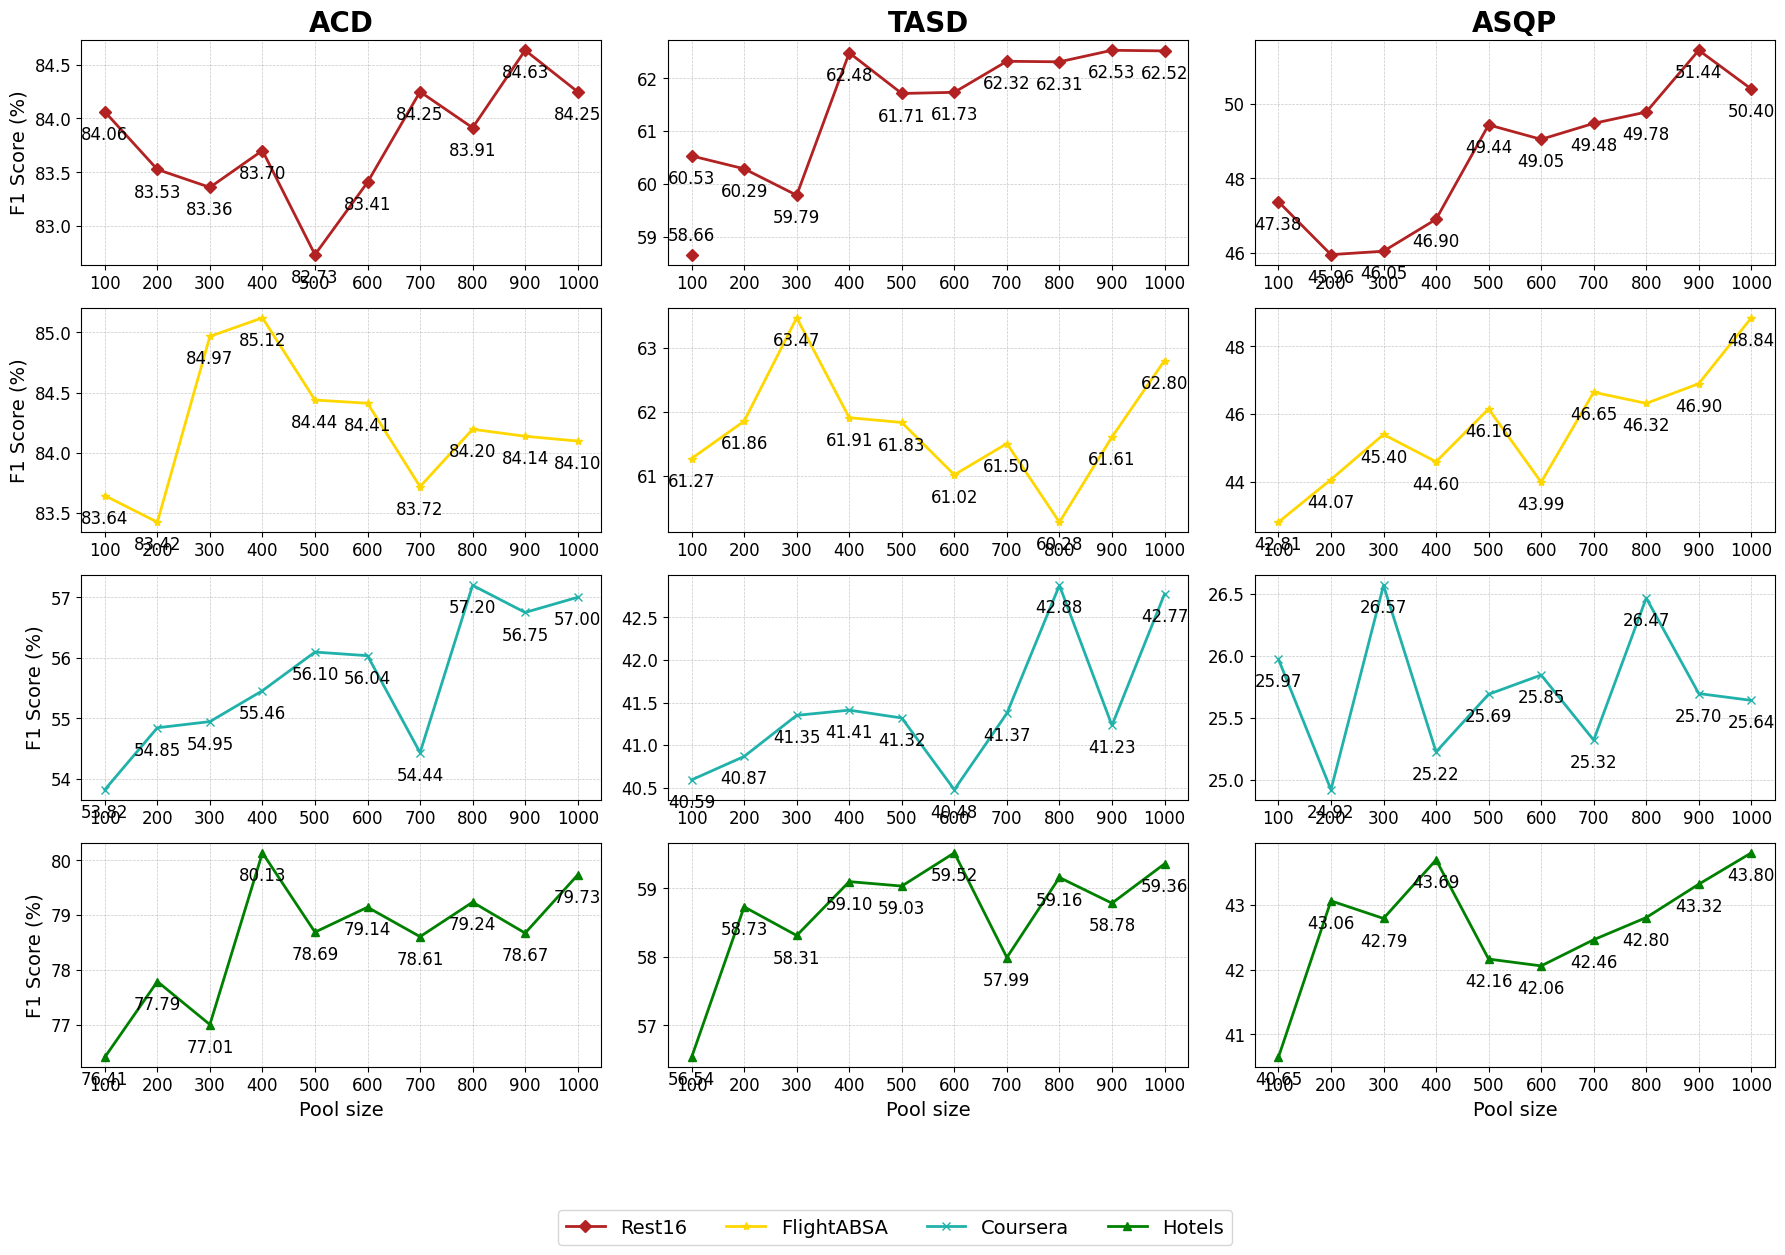

In [22]:
import matplotlib.pyplot as plt

# Set a professional style with Arial font
plt.style.use('default')
# plt.rcParams.update({
#     'font.size': 12,
#     'font.family': 'sans-serif',
#     'font.sans-serif': ['Arial']
# })

fig, axes = plt.subplots(4, 3, figsize=(18, 12))

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

# Define proper display names for datasets
dataset_display_names = {
    "rest16": "Rest16",
    "flightabsa": "FlightABSA", 
    "coursera": "Coursera",
    "hotels": "Hotels"
}

# Define colors and line styles for better distinction
colors = ['firebrick', 'gold', 'lightseagreen', 'green']  # Custom colors for datasets
line_styles = ['-', '--', '-.', ':']

# Define markers for each dataset
markers = {
    "rest16": 'D',      # diamond
    "flightabsa": '*',  # star
    "hotels": '^',      # triangle
    "coursera": 'x'     # x
}

for i, task in enumerate(tasks):
    for j, dataset in enumerate(datasets):
        ax = axes[j, i]
        key_rag = f"{dataset}_{task}_rag"
        key_random = f"{dataset}_{task}_random"
        label = dataset_display_names[dataset]
        marker = markers[dataset]
        
        # Plot RAG line
        if key_rag in f1_scores_all and "f1" in f1_scores_all[key_rag] and len(f1_scores_all[key_rag]["f1"]) > 0:
            k_list = f1_scores_all[key_rag]["k"]
            f1_list = f1_scores_all[key_rag]["f1"]
            ax.plot(k_list, f1_list, label=label, color=colors[j], linestyle='-', linewidth=2, marker=marker, markersize=6)
            # Annotate F1 values
            for x, y in zip(k_list, f1_list):
                ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,-20), ha='center', fontsize=12)
        
        # Plot Random points
        if key_random in f1_scores_all and "f1" in f1_scores_all[key_random] and len(f1_scores_all[key_random]["f1"]) > 0:
            k_list_r = f1_scores_all[key_random]["k"]
            f1_list_r = f1_scores_all[key_random]["f1"]
            ax.plot(k_list_r, f1_list_r, color=colors[j], linestyle='--', linewidth=2, marker=marker, markersize=6)  # Dashed line for Random
            # Annotate F1 values
            for x, y in zip(k_list_r, f1_list_r):
                ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
        
        # Set ticks for x-axis
        ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax.set_xticklabels([f'{int(x * 1000)}' for x in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])
        
        # Add grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        
        # Titles and labels
        if j == 0:
            ax.set_title(f'{task.upper()}', fontsize=20, fontweight='bold')
        if i == 0:
            ax.set_ylabel(f'F1 Score (%)', fontsize=14)
        if j == 3:
            ax.set_xlabel('Pool size', fontsize=14)
        
        # Increase tick label size
        ax.tick_params(axis='both', labelsize=12)

# Collect handles and labels for common legend
handles, labels = [], []
for ax in axes.flatten():
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates
unique_labels = list(dict.fromkeys(labels))  # Preserve order
unique_labels = ["Rest16", "FlightABSA", "Coursera", "Hotels"]
unique_handles = [handles[labels.index(label)] for label in unique_labels if label in labels]

fig.legend(unique_handles, unique_labels, loc='lower center', ncol=4, fontsize=14, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("performance_plot.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
# Statistische Analyse: Vergleich RAG vs Random für jede Task-Dataset-Kombination
from scipy.stats import shapiro, ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

# Sammle p-Werte für alle Task-Dataset-Kombinationen
p_values = []
task_dataset_pairs = []
test_types = []

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

for task in tasks:
    for dataset in datasets:
        key_rag = f"{dataset}_{task}_rag"
        key_random = f"{dataset}_{task}_random"
        
        if key_rag in f1_scores_all and key_random in f1_scores_all:
            f1_rag = f1_scores_all[key_rag]["f1"]
            f1_random = f1_scores_all[key_random]["f1"]
            print(f1_rag)
            print(f1_random)
            
            # Prüfe Normalverteilung
            _, p_norm_rag = shapiro(f1_rag)
            _, p_norm_random = shapiro(f1_random)
            
            if p_norm_rag > 0.05 and p_norm_random > 0.05:
                # Paired t-Test
                _, p_value = ttest_rel(f1_rag, f1_random)
                test_type = "t-test"
            else:
                # Wilcoxon signed-rank test
                try:
                    _, p_value = wilcoxon(f1_rag, f1_random)
                    test_type = "Wilcoxon"
                except ValueError:
                    # All differences are zero
                    p_value = 1.0
                    test_type = "No difference"
            
            p_values.append(p_value)
            task_dataset_pairs.append((task, dataset))
            test_types.append(test_type)
            
            print(f"{task.upper()}-{dataset.capitalize()}: {test_type}, p={p_value:.4f}")

print(f"\nAnzahl Tests: {len(p_values)}")

# Holm-Bonferroni Korrektur
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

print(f"\nHolm-Bonferroni Korrektur (α = 0.05):")
print(f"Anzahl signifikanter Tests: {sum(rejected)}")

for i, (task, dataset) in enumerate(task_dataset_pairs):
    sig_marker = "***" if rejected[i] else "n.s."
    print(f"{task.upper()}-{dataset.capitalize()}: p_raw={p_values[i]:.4f}, p_adj={p_corrected[i]:.4f}, {test_types[i]} {sig_marker}")

[np.float64(84.06256430433731), np.float64(83.5261614551928), np.float64(83.35996858481658), np.float64(83.70191477286747), np.float64(82.73492375878014), np.float64(83.4069369237266), np.float64(84.24804976273286), np.float64(83.91353172375071), np.float64(84.6333753682461), np.float64(84.24785063577556)]
[]
ACD-Rest16: Wilcoxon, p=nan
[np.float64(83.64348677766895), np.float64(83.4225649542325), np.float64(84.96725548494919), np.float64(85.12193014896803), np.float64(84.43840761334803), np.float64(84.4113652550608), np.float64(83.71806040178559), np.float64(84.1952521413526), np.float64(84.13679757617334), np.float64(84.09713920214426)]
[]
ACD-Flightabsa: Wilcoxon, p=nan
[np.float64(53.82395790161134), np.float64(54.84624529258702), np.float64(54.9480578433308), np.float64(55.4579971523493), np.float64(56.09613873950087), np.float64(56.03621730382293), np.float64(54.43605365193778), np.float64(57.197539591905795), np.float64(56.749785814131755), np.float64(57.00021752002998)]
[]
ACD-

/tmp/ipykernel_3104428/3383151380.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_norm_random = shapiro(f1_random)
/home/hellwig/miniconda3/envs/env_nils_hellwig/lib/python3.10/site-packages/scipy/_lib/_util.py:798: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)


In [24]:
times_all = {}
modes = ["random", "rag"]
for mode in modes:
    for dataset_name in ["rest16", "flightabsa", "coursera", "hotels"]:
        for task in ["tasd", "acd", "asqp"]:
            for k in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
                
                if mode == "random":
                  pred_phrase = "predictions_random"
                else:
                  pred_phrase = "predictions"
                try:
                    with open(f"./predictions/seed_42/{task}/{model}/{k}/{dataset_name}/predictions.json", 'r') as f:
                       data = json.load(f)
                except FileNotFoundError:
                    data = []
                
                times = [example["time"] for example in data]
                times_all[f"{dataset_name}_{task}_{mode}_{k}"] = np.mean(times)
            

In [25]:
import pandas as pd

# Create a list to hold the data
data = []
modes = ["random", "rag"]
k_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for mode in modes:
    for task in tasks:
        for k in k_values:
            for dataset in datasets:
                key = f"{dataset}_{task}_{mode}_{k}"
                if key in times_all and not np.isnan(times_all[key]):
                    data.append({"task": task.upper(), "k": int(k * 1000), "dataset": dataset.capitalize(), "mode": mode.capitalize(), "time": times_all[key]})

# Create DataFrame
df_times = pd.DataFrame(data)

# Calculate average time per task, k, and mode over all datasets
df_avg = df_times.groupby(['task', 'k', 'mode'])['time'].mean().reset_index()

# Pivot the DataFrame
df_pivot = df_avg.pivot(index='k', columns=['task', 'mode'], values='time')

# Sort columns
df_pivot = df_pivot.sort_index(axis=1)

# Display the pivoted DataFrame
df_pivot

task       ACD                ASQP                TASD          
mode       Rag    Random       Rag    Random       Rag    Random
k                                                               
100   1.032641  1.032641  2.219282  2.219282  1.642823  1.642823
200   1.077954  1.077954  2.239419  2.239419  1.630460  1.630460
300   1.067192  1.067192  2.234997  2.234997  1.644075  1.644075
400   1.076379  1.076379  2.252021  2.252021  1.656138  1.656138
500   1.078541  1.078541  2.271951  2.271951  1.680124  1.680124
600   1.087769  1.087769  2.277228  2.277228  1.650671  1.650671
700   1.082563  1.082563  2.271693  2.271693  1.676521  1.676521
800   1.074874  1.074874  2.286558  2.286558  1.684651  1.684651
900   1.116573  1.116573  2.275599  2.275599  1.672742  1.672742
1000  1.090109  1.090109  2.294458  2.294458  1.681132  1.681132

In [26]:
with open('performance_latex/muster_time.txt', 'r') as f:
    content = f.read()

for row in df_pivot.itertuples(index=False):
    for value in row:
        if isinstance(value, (float, np.floating)):
            if np.isnan(value):
               rep = "n.a."
            else:
               rep = f"{value:.3f}"
        else:
            rep = str(value)
        content = content.replace("xxxx", rep, 1)

with open('performance_latex/out_time.txt', 'w') as f:
    f.write(content)